# Obesity Estimation - Feature Engineering and Machine Learning Models

### In this notebook we will implement various Machine Learning Classification alogrithms to select the best performing model
1) Decision Tree </br>
2) Random Forest</br>
3) KNN </br>
4) XGBClassifier</br>


### We will use the following steps:
##### Split the Dataset:
Split the dataset into training and test sets before applying transformations to avoid data leakage.
##### One-Hot Encoding:
Apply one-hot encoding only to the training set using fit_transform.</br>
Use the same encoder to transform the test set with transform, ensuring consistency.</br>
Handle unknown categories with handle_unknown='ignore'.
##### Label Encoding for Target Variable:
Apply label encoding to the entire target column (train + test) for consistent label mappings across splits.
This is safe as it will not allow information to leak from features to the model.
##### Feature Scaling:
Apply scaling (e.g., StandardScaler or MinMaxScaler) only to the training set using fit_transform.
Use the same scaler to transform the test set with transform.
##### Save Encoders/Scalers:
Save the fitted encoders and scalers to ensure consistent transformations for future data.

#####  GridsearchCV and 5-fold cross-validation to compare the accuracies.

In [1]:
import pandas as pd

In [2]:
# Read data and convert to a dataframe
clean_data_df = pd.read_csv(r'../data/clean_data.csv')

clean_data_df.info()

clean_data_df.drop('BMI', axis='columns', inplace=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2087 entries, 0 to 2086
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Gender                     2087 non-null   object 
 1   Age                        2087 non-null   float64
 2   Height                     2087 non-null   float64
 3   Weight                     2087 non-null   float64
 4   Family_History             2087 non-null   object 
 5   High_Cal_Foods_Frequently  2087 non-null   object 
 6   Freq_Veg                   2087 non-null   float64
 7   Num_Meals                  2087 non-null   float64
 8   Snacking                   2087 non-null   object 
 9   Smoke                      2087 non-null   object 
 10  Water_Intake               2087 non-null   float64
 11  Calorie_Monitoring         2087 non-null   object 
 12  Phys_Activity              2087 non-null   float64
 13  Tech_Use                   2087 non-null   float

In [3]:
# Feature columns by preprocessing type: categorical and continous

cat_cols = ['Gender', 'Family_History', 'High_Cal_Foods_Frequently', 'Snacking','Smoke', 'Calorie_Monitoring', 'Freq_Alcohol', 'Transportation']

num_cols = ['Age', 'Height', 'Weight', 'Freq_Veg', 'Num_Meals','Water_Intake', 'Phys_Activity', 'Tech_Use']

### Define dataframes X and y 

In [4]:
X = clean_data_df.drop('Obesity_Level',axis=1)  
y = clean_data_df['Obesity_Level'] 

X.shape, y.shape

((2087, 16), (2087,))

### Train test split - stratified splitting
Stratified splitting means that when you generate a training / validation dataset split, it will attempt to keep the same percentages of classes in each split.

These dataset divisions are usually generated randomly according to a target variable. However, when doing so, the proportions of the target variable among the different splits can differ, especially in the case of small datasets.

In [5]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,stratify=y,test_size=0.2,random_state=42)

In [6]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1669, 16), (418, 16), (1669,), (418,))

### Scaling - OneHot for cat columns and Standard scaling for num columns

In [7]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler
Sscaler = StandardScaler().set_output(transform="pandas")
# Encoding multiple columns. 
transformer = make_column_transformer((Sscaler, num_cols), (OneHotEncoder(handle_unknown='ignore'), 
     cat_cols),verbose=True,verbose_feature_names_out=True, remainder='drop')

transformer

ColumnTransformer(transformers=[('standardscaler', StandardScaler(),
                                 ['Age', 'Height', 'Weight', 'Freq_Veg',
                                  'Num_Meals', 'Water_Intake', 'Phys_Activity',
                                  'Tech_Use']),
                                ('onehotencoder',
                                 OneHotEncoder(handle_unknown='ignore'),
                                 ['Gender', 'Family_History',
                                  'High_Cal_Foods_Frequently', 'Snacking',
                                  'Smoke', 'Calorie_Monitoring', 'Freq_Alcohol',
                                  'Transportation'])],
                  verbose=True)

### X_train encoding

In [8]:
# Transforming
transformed = transformer.fit_transform(X_train)
# Transformating back
transformed_df = pd.DataFrame(transformed, columns=transformer.get_feature_names_out())
# One-hot encoding removed an index. Let's put it back:
transformed_df.index = X_train.index
# Joining tables
X_train = pd.concat([X_train, transformed_df], axis=1)
# Dropping old categorical columns
X_train.drop(cat_cols, axis=1, inplace=True)
# Dropping old num columns
X_train.drop(num_cols, axis=1, inplace=True)
# CHecking result
#print(X_train.head())
print(X_train.columns)
print(X_train.shape)

[ColumnTransformer]  (1 of 2) Processing standardscaler, total=   0.0s
[ColumnTransformer] . (2 of 2) Processing onehotencoder, total=   0.0s
Index(['standardscaler__Age', 'standardscaler__Height',
       'standardscaler__Weight', 'standardscaler__Freq_Veg',
       'standardscaler__Num_Meals', 'standardscaler__Water_Intake',
       'standardscaler__Phys_Activity', 'standardscaler__Tech_Use',
       'onehotencoder__Gender_Female', 'onehotencoder__Gender_Male',
       'onehotencoder__Family_History_no', 'onehotencoder__Family_History_yes',
       'onehotencoder__High_Cal_Foods_Frequently_no',
       'onehotencoder__High_Cal_Foods_Frequently_yes',
       'onehotencoder__Snacking_Always', 'onehotencoder__Snacking_Frequently',
       'onehotencoder__Snacking_Sometimes', 'onehotencoder__Snacking_no',
       'onehotencoder__Smoke_no', 'onehotencoder__Smoke_yes',
       'onehotencoder__Calorie_Monitoring_no',
       'onehotencoder__Calorie_Monitoring_yes',
       'onehotencoder__Freq_Alcohol_A

### X_test encoding

In [9]:
# Transforming
transformed = transformer.transform(X_test)
# Transformating back
transformed_df = pd.DataFrame(transformed, columns=transformer.get_feature_names_out())
# One-hot encoding removed an index. Let's put it back:
transformed_df.index = X_test.index
# Joining tables
X_test = pd.concat([X_test, transformed_df], axis=1)
# Dropping old categorical columns
X_test.drop(cat_cols, axis=1, inplace=True)
# Dropping old num columns
X_test.drop(num_cols, axis=1, inplace=True)
# CHecking result
X_test.head()

,standardscaler__Age,standardscaler__Height,standardscaler__Weight,standardscaler__Freq_Veg,standardscaler__Num_Meals,standardscaler__Water_Intake,standardscaler__Phys_Activity,standardscaler__Tech_Use,onehotencoder__Gender_Female,onehotencoder__Gender_Male,...,onehotencoder__Calorie_Monitoring_yes,onehotencoder__Freq_Alcohol_Always,onehotencoder__Freq_Alcohol_Frequently,onehotencoder__Freq_Alcohol_Sometimes,onehotencoder__Freq_Alcohol_no,onehotencoder__Transportation_Automobile,onehotencoder__Transportation_Bike,onehotencoder__Transportation_Motorbike,onehotencoder__Transportation_Public_Transportation,onehotencoder__Transportation_Walking
1153,-0.690071,-1.202029,-0.537291,1.084280,1.512030,-0.000656,0.376859,0.550747,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
132,0.899810,0.736866,0.848928,1.084280,0.391801,-1.644954,1.182627,-1.095082,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
1923,-0.587828,0.401573,1.579131,1.084280,0.391801,-0.334381,0.499952,0.495086,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
846,-1.165664,-1.047678,-0.831968,1.008997,-2.224232,-0.000656,-0.324357,1.117030,1.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1246,0.821665,1.347473,0.839435,-0.801583,0.231677,0.588066,-0.155934,1.895629,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0


In [10]:
print(X_train.columns, X_train.shape)

Index(['standardscaler__Age', 'standardscaler__Height',
       'standardscaler__Weight', 'standardscaler__Freq_Veg',
       'standardscaler__Num_Meals', 'standardscaler__Water_Intake',
       'standardscaler__Phys_Activity', 'standardscaler__Tech_Use',
       'onehotencoder__Gender_Female', 'onehotencoder__Gender_Male',
       'onehotencoder__Family_History_no', 'onehotencoder__Family_History_yes',
       'onehotencoder__High_Cal_Foods_Frequently_no',
       'onehotencoder__High_Cal_Foods_Frequently_yes',
       'onehotencoder__Snacking_Always', 'onehotencoder__Snacking_Frequently',
       'onehotencoder__Snacking_Sometimes', 'onehotencoder__Snacking_no',
       'onehotencoder__Smoke_no', 'onehotencoder__Smoke_yes',
       'onehotencoder__Calorie_Monitoring_no',
       'onehotencoder__Calorie_Monitoring_yes',
       'onehotencoder__Freq_Alcohol_Always',
       'onehotencoder__Freq_Alcohol_Frequently',
       'onehotencoder__Freq_Alcohol_Sometimes',
       'onehotencoder__Freq_Alcohol_n

In [11]:
# Setting new feature names

X_train.columns = ['Age', 'Height', 'Weight', 'Freq_Veg', 'Num_Meals', 'Water_Intake',
       'Phys_Activity', 'Tech_Use', 'Gender_Female',
       'Gender_Male', 'Family_History_no',
       'Family_History_yes',
       'High_Cal_Foods_Frequently_no',
       'High_Cal_Foods_Frequently_yes',
       'Snacking_Always', 'Snacking_Frequently',
       'Snacking_Sometimes', 'Snacking_no',
       'Smoke_no', 'Smoke_yes',
       'Calorie_Monitoring_no',
       'Calorie_Monitoring_yes',
       'Freq_Alcohol_Always',
       'Freq_Alcohol_Frequently',
       'Freq_Alcohol_Sometimes',
       'Freq_Alcohol_no',
       'Transportation_Automobile',
       'Transportation_Bike',
       'Transportation_Motorbike',
       'Transportation_Public_Transportation',
       'Transportation_Walking']

X_test.columns = ['Age', 'Height', 'Weight', 'Freq_Veg', 'Num_Meals', 'Water_Intake',
       'Phys_Activity', 'Tech_Use', 'Gender_Female',
       'Gender_Male', 'Family_History_no',
       'Family_History_yes',
       'High_Cal_Foods_Frequently_no',
       'High_Cal_Foods_Frequently_yes',
       'Snacking_Always', 'Snacking_Frequently',
       'Snacking_Sometimes', 'Snacking_no',
       'Smoke_no', 'Smoke_yes',
       'Calorie_Monitoring_no',
       'Calorie_Monitoring_yes',
       'Freq_Alcohol_Always',
       'Freq_Alcohol_Frequently',
       'Freq_Alcohol_Sometimes',
       'Freq_Alcohol_no',
       'Transportation_Automobile',
       'Transportation_Bike',
       'Transportation_Motorbike',
       'Transportation_Public_Transportation',
       'Transportation_Walking']
# After renaming the columns

X_train.head()


,Age,Height,Weight,Freq_Veg,Num_Meals,Water_Intake,Phys_Activity,Tech_Use,Gender_Female,Gender_Male,...,Calorie_Monitoring_yes,Freq_Alcohol_Always,Freq_Alcohol_Frequently,Freq_Alcohol_Sometimes,Freq_Alcohol_no,Transportation_Automobile,Transportation_Bike,Transportation_Motorbike,Transportation_Public_Transportation,Transportation_Walking
1549,0.248290,0.705537,1.045026,-0.375885,0.391801,0.253102,0.308538,-0.452916,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1574,1.008501,-0.608067,0.505277,1.016483,-0.755149,-1.644954,0.823971,-0.073903,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1155,3.702329,0.457500,-0.078269,0.207948,0.391801,-1.403908,-0.827757,-1.095082,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
610,-0.208354,0.416482,-1.265285,-0.345947,0.391801,-0.252848,1.731352,0.245475,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
906,-0.523216,-1.012212,-0.725998,-0.801583,0.596256,1.643643,0.204484,-0.952112,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


### Apply Label encoder

#### Encoding y_train

In [12]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)

y_train.head(10) , y_train_encoded[0:10]




(1549        Obesity_Type_II
 1574        Obesity_Type_II
 1155    Overweight_Level_II
 610     Insufficient_Weight
 906      Overweight_Level_I
 18      Overweight_Level_II
 191           Normal_Weight
 1696        Obesity_Type_II
 1676        Obesity_Type_II
 2004       Obesity_Type_III
 Name: Obesity_Level, dtype: object,
 array([3, 3, 6, 0, 5, 6, 1, 3, 3, 4]))

#### Encoding y_test

In [13]:
le_test = LabelEncoder()
y_test_encoded = le_test.fit_transform(y_test)
y_test.head(10) , y_test_encoded[0:10]

(1153    Overweight_Level_II
 132          Obesity_Type_I
 1923       Obesity_Type_III
 846      Overweight_Level_I
 1246         Obesity_Type_I
 1236         Obesity_Type_I
 1372         Obesity_Type_I
 1010    Overweight_Level_II
 337        Obesity_Type_III
 1524        Obesity_Type_II
 Name: Obesity_Level, dtype: object,
 array([6, 2, 4, 5, 2, 2, 2, 6, 4, 3]))

### Classifier Models 

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

##### Models in consideration - RandomForest, DecisionTree, KNN, XGBoost

In [15]:
models={'RandomForest':RandomForestClassifier(),
        'DecisionTree':DecisionTreeClassifier(),
        'KNeighbors':KNeighborsClassifier(),
        'xgbc': XGBClassifier()}

##### Scoring for measuring model performance

In [16]:
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score
scoring = {
    'accuracy': 'accuracy',
    'precision': make_scorer(precision_score, average='weighted'),
    'recall': make_scorer(recall_score, average='weighted'),
    'f1': make_scorer(f1_score, average='weighted')}

##### Model Evalution

In [17]:
from sklearn.model_selection import cross_val_score

# Define the function to compare models with default parameters
def evaluate_models(X, Y, models, scorings, cross_validation):
    best_models = {}
    result = {}
    
    # Loop through models and evaluate each one
    for model_name, model in models.items():
        print(f"\nEvaluating {model_name}...")
        
        # Evaluate using the defined scoring metrics
        model_scores = {}
        for score_name, scorer in scorings.items():
            score = cross_val_score(model, X, Y, cv=cross_validation, scoring=scorer)
            model_scores[score_name] = score.mean()
        
        # Store results
        result[model_name] = model_scores
        
        # Print the results
        print(f"Accuracy: {model_scores['accuracy']:.4f}")
        print(f"Precision: {model_scores['precision']:.4f}")
        print(f"Recall: {model_scores['recall']:.4f}")
        print(f"F1 Score: {model_scores['f1']:.4f}")
    
    return result


### Models Performance Visuals

In [18]:
result = evaluate_models(X_train, y_train_encoded, models, scoring, 5)


Evaluating RandomForest...
Accuracy: 0.9293
Precision: 0.9347
Recall: 0.9347
F1 Score: 0.9341

Evaluating DecisionTree...
Accuracy: 0.9167
Precision: 0.9192
Recall: 0.9167
F1 Score: 0.9161

Evaluating KNeighbors...
Accuracy: 0.8113
Precision: 0.8105
Recall: 0.8113
F1 Score: 0.7941

Evaluating xgbc...
Accuracy: 0.9629
Precision: 0.9633
Recall: 0.9629
F1 Score: 0.9628


## Creating a comparison table for the Models

In [19]:
result_df = pd.DataFrame(result).T


In [20]:
result_df

,accuracy,precision,recall,f1
RandomForest,0.929302,0.934700,0.934696,0.934060
DecisionTree,0.916725,0.919221,0.916725,0.916058
KNeighbors,0.811273,0.810466,0.811273,0.794125
xgbc,0.962854,0.963345,0.962854,0.962758


The results highlight that the xgbc model outperforms others with the highest accuracy (96.3%), precision (96.3%), recall (96.3%), and F1 score (96.3%), demonstrating its superior ability to classify data correctly. The RandomForest model also shows strong performance, achieving an accuracy of 93.6%, making it a competitive alternative. In comparison, the DecisionTree model and KNeighbors model perform slightly lower, with accuracies of 91.2% and 81.1%, respectively. Based on these findings, we have decided to conduct further comparisons between RandomForest and XGBoost to refine our model selection process.

#### Accuracy Comparison

C:\Users\arezo\AppData\Local\Temp\ipykernel_19356\1895503191.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=result_df.index, y='accuracy', data=result_df, palette="Blues_d")


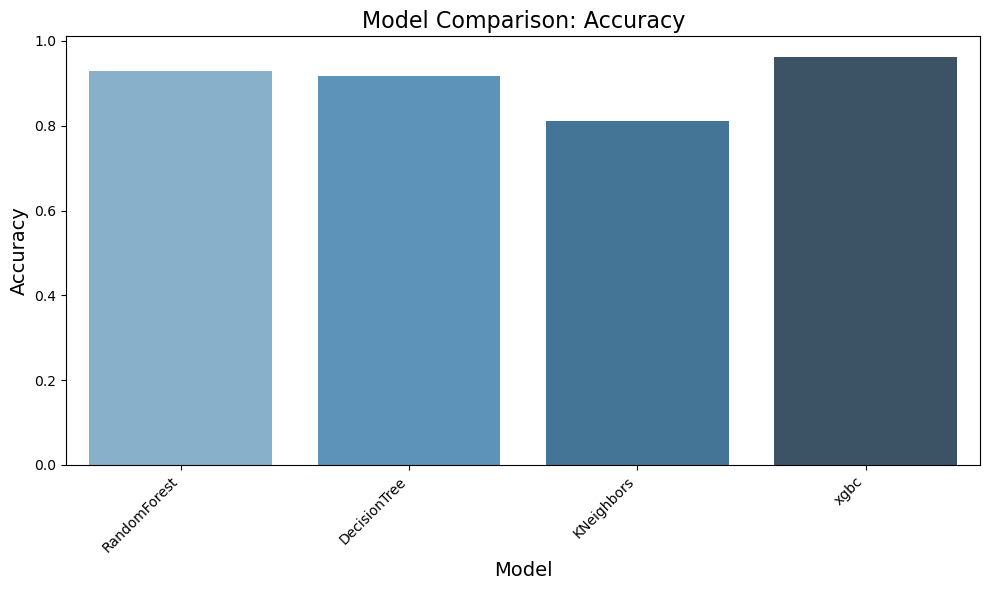

In [21]:
# Plot Accuracy
import matplotlib.pyplot as plt 
import seaborn as sns 
plt.figure(figsize=(10, 6))
sns.barplot(x=result_df.index, y='accuracy', data=result_df, palette="Blues_d")
plt.title('Model Comparison: Accuracy', fontsize=16)
plt.ylabel('Accuracy', fontsize=14)
plt.xlabel('Model', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

#### Precision Comparison

C:\Users\arezo\AppData\Local\Temp\ipykernel_19356\3424882693.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=result_df.index, y='precision', data=result_df, palette="Greens_d")


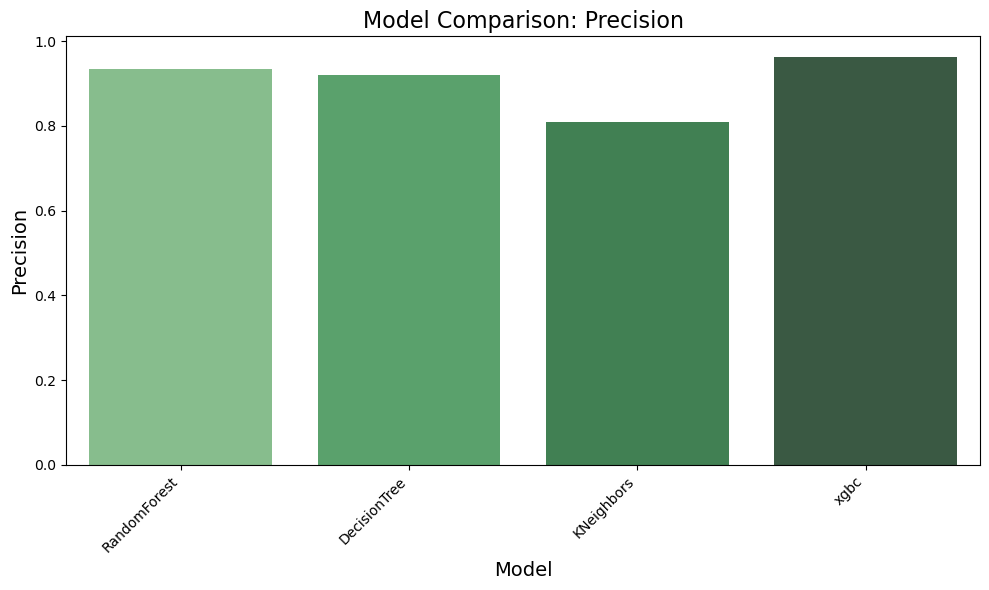

In [22]:
# Plot Precision
plt.figure(figsize=(10, 6))
sns.barplot(x=result_df.index, y='precision', data=result_df, palette="Greens_d")
plt.title('Model Comparison: Precision', fontsize=16)
plt.ylabel('Precision', fontsize=14)
plt.xlabel('Model', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

#### Recall Comparison

C:\Users\arezo\AppData\Local\Temp\ipykernel_19356\900479777.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=result_df.index, y='recall', data=result_df, palette="Oranges_d")


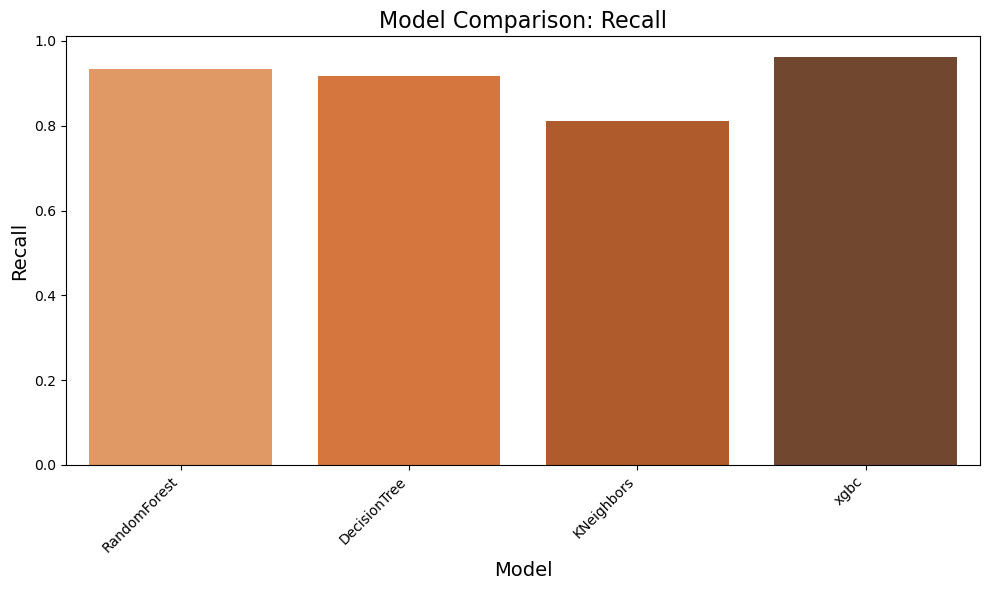

In [23]:
# Plot Precision
plt.figure(figsize=(10, 6))
sns.barplot(x=result_df.index, y='recall', data=result_df, palette="Oranges_d")
plt.title('Model Comparison: Recall', fontsize=16)
plt.ylabel('Recall', fontsize=14)
plt.xlabel('Model', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Based on Visuals above we can clearly notice that RandomForest and XGBC models are showing good results. We will tune the parameters next to find the best suitable model

#### Hyper tuning the two best models - Random Forest and XGBC

In [24]:
models={'RandomForest_hyper_tuned':RandomForestClassifier(),
        'xgbc_hyper_tuned': XGBClassifier()}

In [25]:
# Hyperparameter grids for tuning models
param_grids = {
    
    # Random Forest Hyperparameter Grid
    'RandomForest_hyper_tuned': {
        'n_estimators': [50, 100, 200, 400],               # Number of trees in the forest
        'max_depth': [None, 10, 20, 50],                   # Maximum depth of each tree
        'min_samples_split': [2, 5, 10, 15]                # Minimum number of samples to split a node
    },
    
    # XGBoostClassifier Hyperparameter Grid
    'xgbc_hyper_tuned': {
        'n_estimators': [50, 100, 200, 400],               # Number of boosting rounds
        'max_depth': [3, 5, 7, 10],                        # Maximum depth of each tree
        'learning_rate': [0.001, 0.01, 0.1, 0.3],          # Step size shrinkage
        'objective': ['multi:softmax'],                    # Multi-class classification
        'verbosity': [0],                                  # Silence output
        'nthread': [-1],                                   # Use all available threads
        'random_state': [42]                               # Ensure reproducibility
    }
}

In [26]:
# %reload ../models/Models_eval.py

from sklearn.model_selection import GridSearchCV

def grid_search_cv_eval(X,Y, models, param_grid, scorings,cross_validation):

    best_models = {}
    result = {}
    for model in models:
        print(result)
        print(f"\nRunning GridSearch for {model}...")
        gsv = GridSearchCV(
            estimator=models[model],
            param_grid=param_grid[model],
            cv=cross_validation,
            scoring=scorings,
            refit='accuracy'  # Primary metric for model selection
        )
        gsv.fit(X, Y)
        best_models[model] = gsv.best_estimator_
        best_index = gsv.best_index_
        print(f'Best parameters for {model}: {gsv.best_params_}')
        print(f'Best accuracy: {gsv.cv_results_["mean_test_accuracy"][best_index]:.4f}')
        print(f'Best precision: {gsv.cv_results_["mean_test_precision"][best_index]:.4f}')
        print(f'Best recall: {gsv.cv_results_["mean_test_recall"][best_index]:.4f}')
        result[model] = {"parameter":gsv.best_params_,"accuracy":gsv.cv_results_["mean_test_accuracy"][best_index], "precision": gsv.cv_results_["mean_test_precision"][best_index],"recall": gsv.cv_results_["mean_test_recall"][best_index]}

    return best_models, result

In [27]:
best_models_hyper_tuned, result_hyper_tuned = grid_search_cv_eval(X_train, y_train_encoded, models, param_grids, scoring, cross_validation=5)
best_models_hyper_tuned, result_hyper_tuned

{}

Running GridSearch for RandomForest_hyper_tuned...
Best parameters for RandomForest_hyper_tuned: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 400}
Best accuracy: 0.9365
Best precision: 0.9416
Best recall: 0.9365
{'RandomForest_hyper_tuned': {'parameter': {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 400}, 'accuracy': 0.936498174821528, 'precision': 0.9416090466755612, 'recall': 0.936498174821528}}

Running GridSearch for xgbc_hyper_tuned...
Best parameters for xgbc_hyper_tuned: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 400, 'nthread': -1, 'objective': 'multi:softmax', 'random_state': 42, 'verbosity': 0}
Best accuracy: 0.9664
Best precision: 0.9669
Best recall: 0.9664


({'RandomForest_hyper_tuned': RandomForestClassifier(n_estimators=400),
  'xgbc_hyper_tuned': XGBClassifier(base_score=None, booster=None, callbacks=None,
                colsample_bylevel=None, colsample_bynode=None,
                colsample_bytree=None, device=None, early_stopping_rounds=None,
                enable_categorical=False, eval_metric=None, feature_types=None,
                gamma=None, grow_policy=None, importance_type=None,
                interaction_constraints=None, learning_rate=0.1, max_bin=None,
                max_cat_threshold=None, max_cat_to_onehot=None,
                max_delta_step=None, max_depth=5, max_leaves=None,
                min_child_weight=None, missing=nan, monotone_constraints=None,
                multi_strategy=None, n_estimators=400, n_jobs=None, nthread=-1,
                num_parallel_tree=None, ...)},
 {'RandomForest_hyper_tuned': {'parameter': {'max_depth': None,
    'min_samples_split': 2,
    'n_estimators': 400},
   'accuracy': 0.936

### Feature Importance

C:\Users\arezo\AppData\Local\Temp\ipykernel_19356\2094430465.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(y=fimp.index, x=fimp.values, palette=palette, orient='h')
C:\Users\arezo\AppData\Local\Temp\ipykernel_19356\2094430465.py:16: UserWarning: 
The palette list has fewer values (4) than needed (31) and will cycle, which may produce an uninterpretable plot.
  ax = sns.barplot(y=fimp.index, x=fimp.values, palette=palette, orient='h')


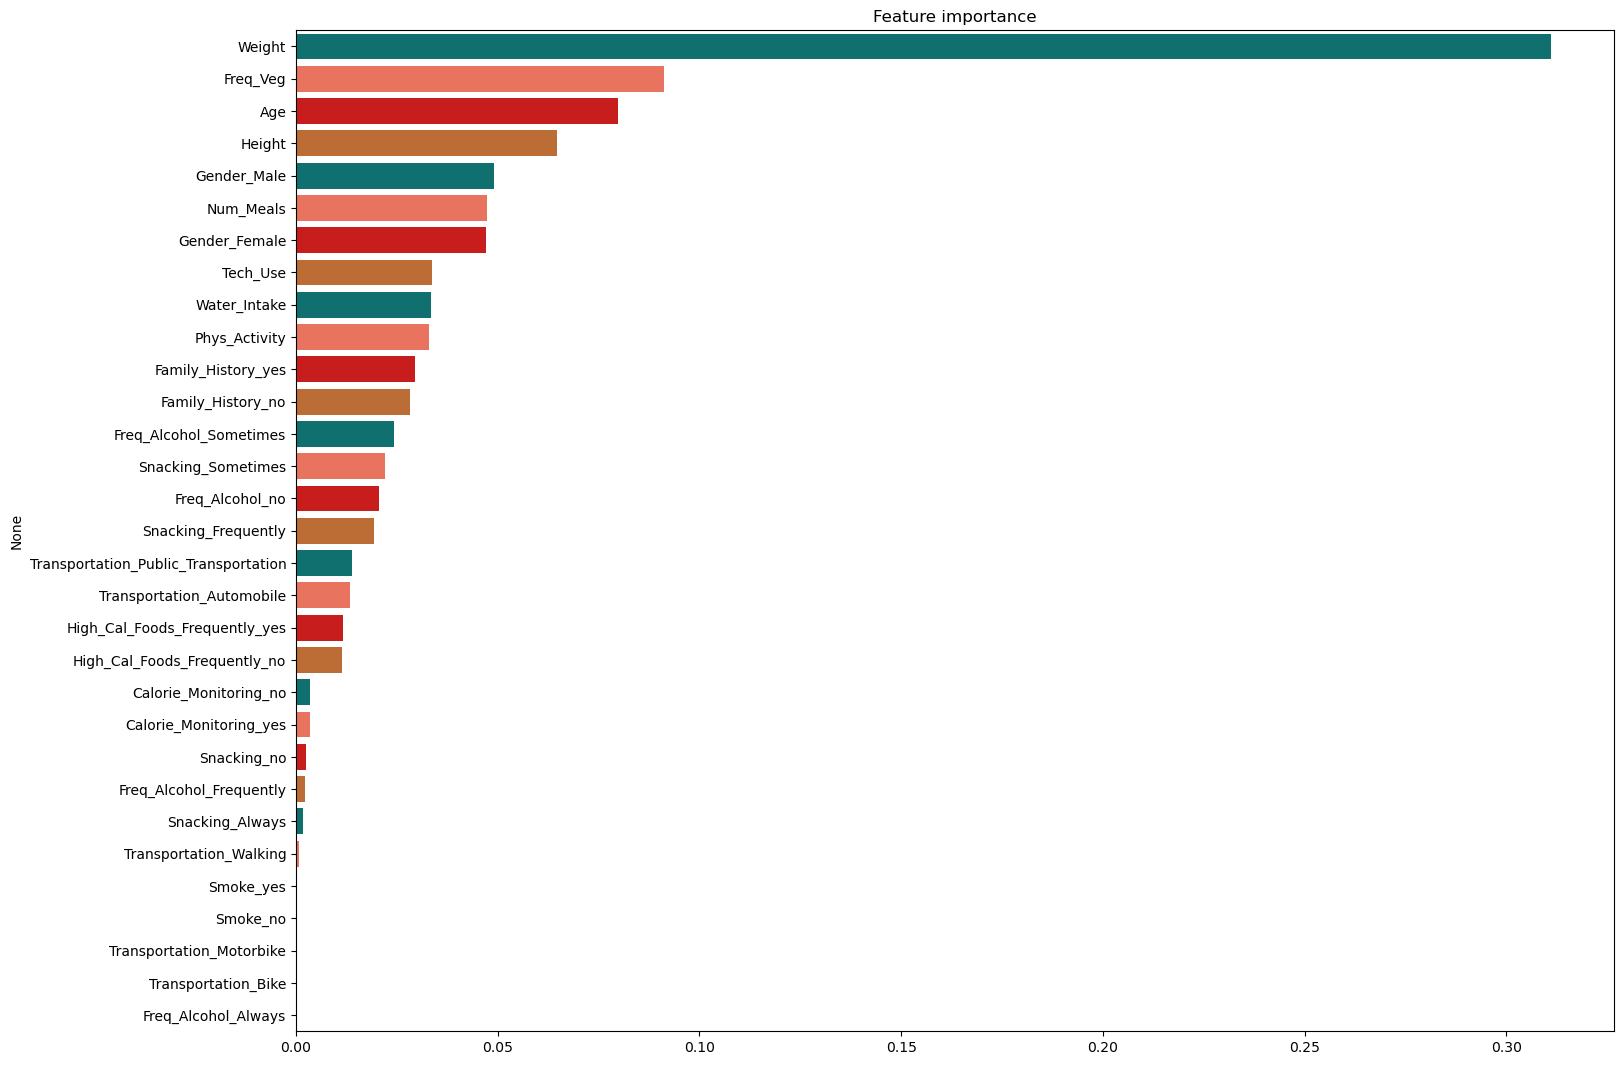

In [28]:
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import plotly.express as px

from matplotlib import pyplot as plt
from sklearn.model_selection import cross_val_score

palette = ['#008080','#FF6347', '#E50000', '#D2691E'] # Creating color palette for plots

clf = RandomForestClassifier(max_depth=8, min_samples_leaf=3, min_samples_split=3, n_estimators=5000, random_state=13)
clf = clf.fit(X_train, y_train)

fimp = pd.Series(data=clf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
plt.figure(figsize=(17,13))
plt.title("Feature importance")
ax = sns.barplot(y=fimp.index, x=fimp.values, palette=palette, orient='h')

#### Classic feature attributions
Here we try out the global feature importance calcuations that come with XGBoost. 

In [29]:
xgboot_model = best_models_hyper_tuned.get('xgbc_hyper_tuned')
xgboot_model

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=400, n_jobs=None, nthread=-1,
              num_parallel_tree=None, ...)

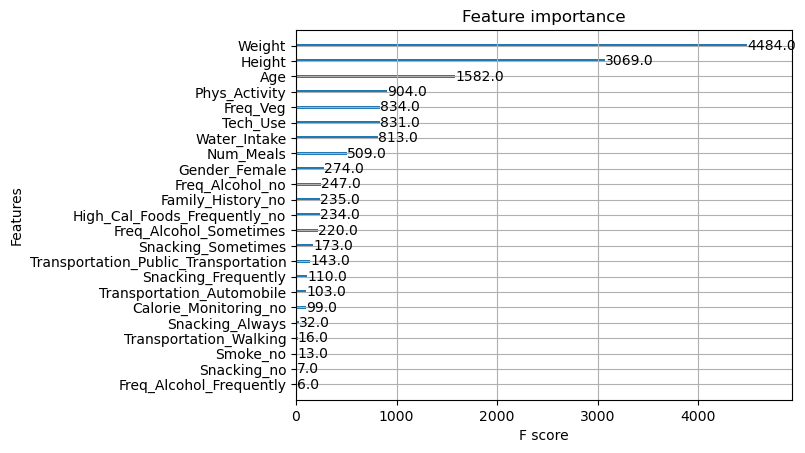

In [30]:
import xgboost
xgboost.plot_importance(xgboot_model)
#plt.title("xgboost plot_importance(model)")
plt.show()

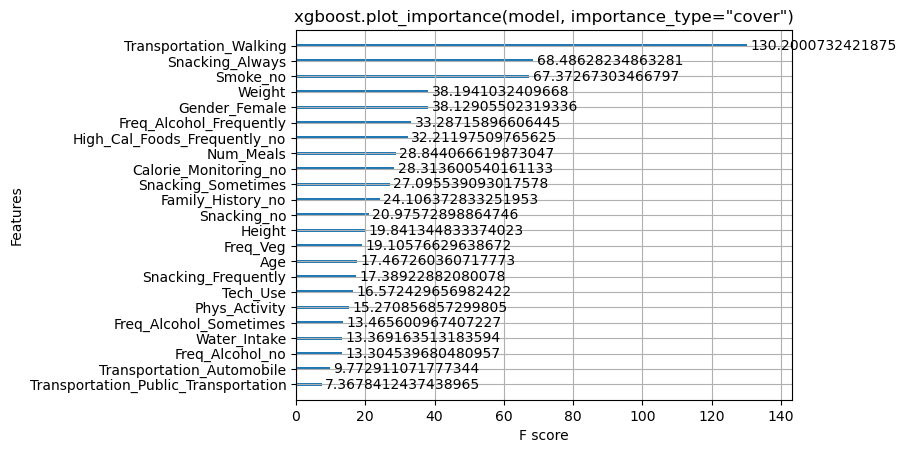

In [31]:
xgboost.plot_importance(xgboot_model, importance_type="cover")
plt.title('xgboost.plot_importance(model, importance_type="cover")')
plt.show()

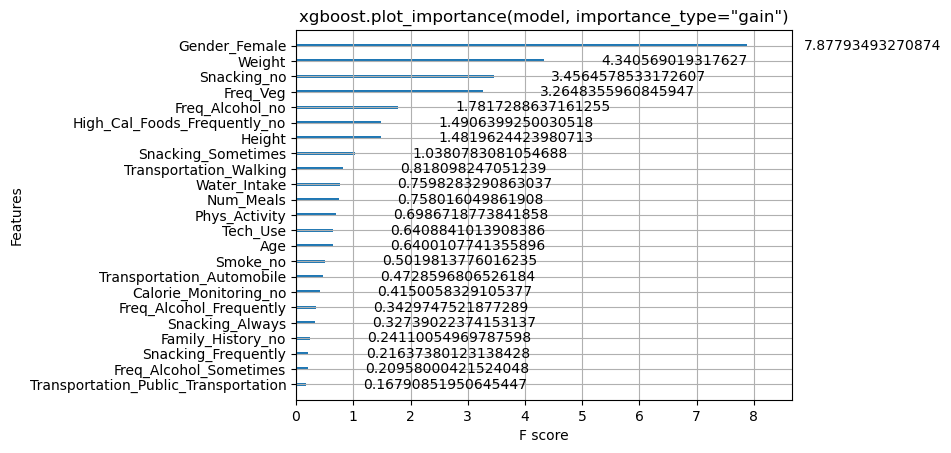

In [32]:
xgboost.plot_importance(xgboot_model, importance_type="gain")
plt.title('xgboost.plot_importance(model, importance_type="gain")')
plt.show()

### SHAP Explainibity

In [33]:
### code here

import shap

# print the JS visualization code to the notebook
shap.initjs()

c:\Users\arezo\miniconda3\envs\dsi_participant\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [34]:
explainer = shap.TreeExplainer(xgboot_model)
shap_values = explainer.shap_values(X_train)

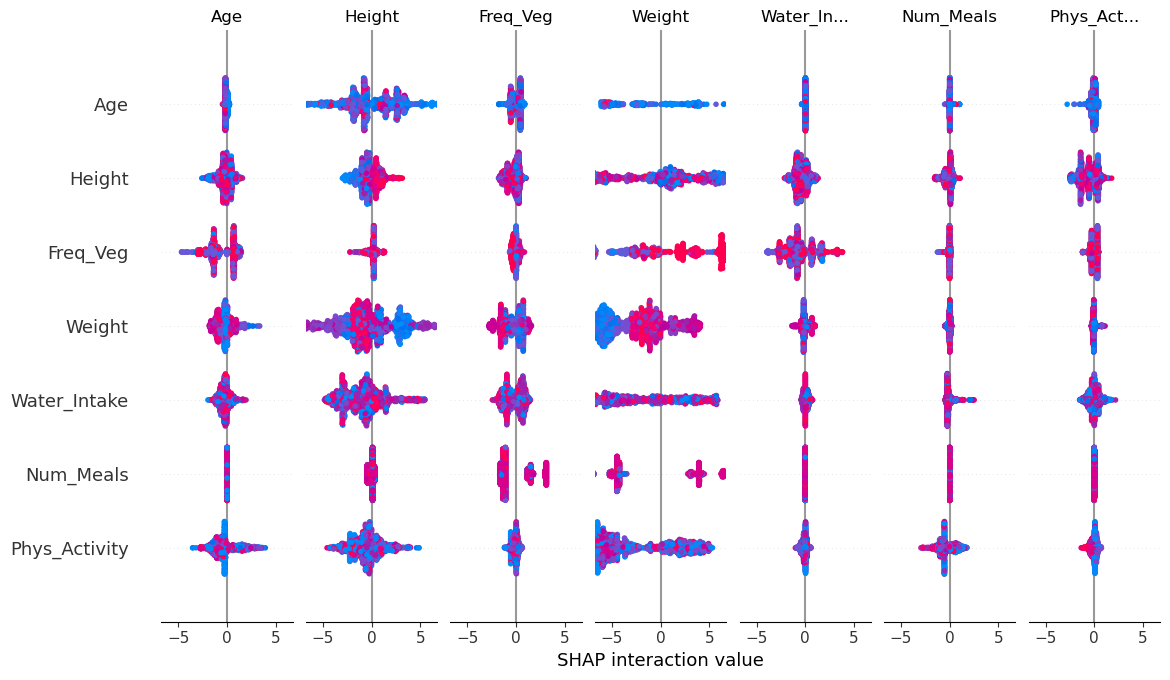

In [35]:
shap.summary_plot(shap_values, X_train, plot_type="bar")

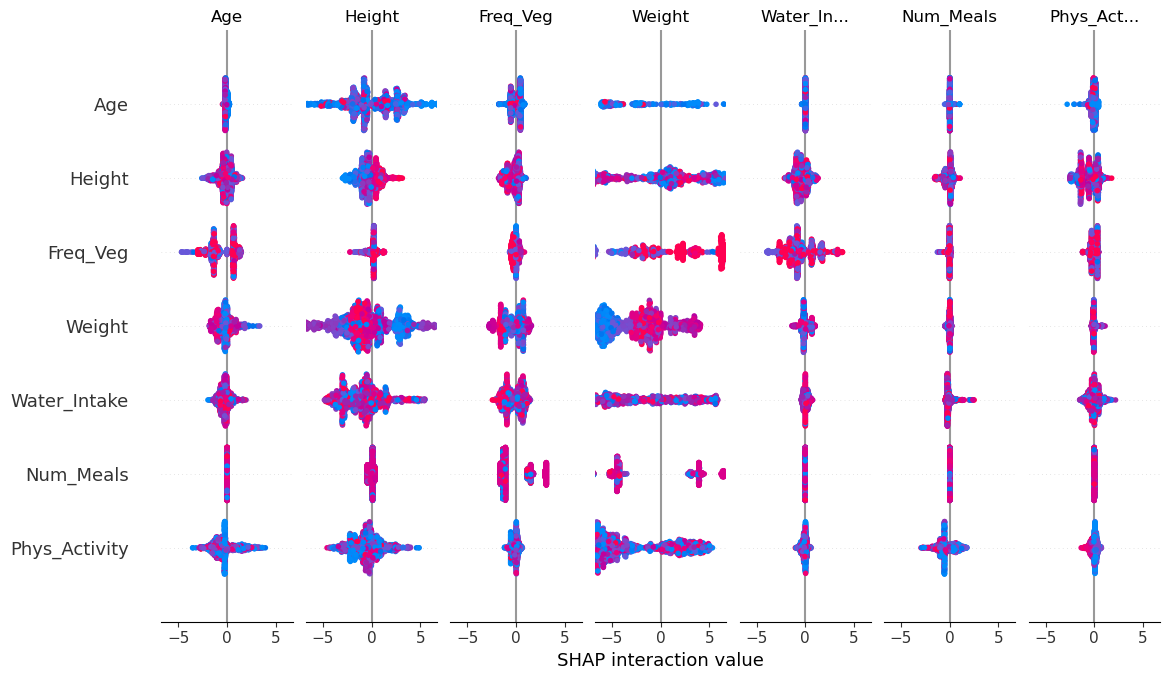

In [36]:
shap.summary_plot(shap_values, X_train)